[28.2746, 28.1324, 27.9456, 27.8226, 27.75, 27.4674, 27.2275, 26.8867, 26.8928, 26.6175, 26.2767, 27.2142]
[34.7396, 34.157, 33.8449, 32.629, 33.6427, 33.5116, 32.3463, 31.9239, 31.8317, 30.8231, 30.5953, 30.9221]


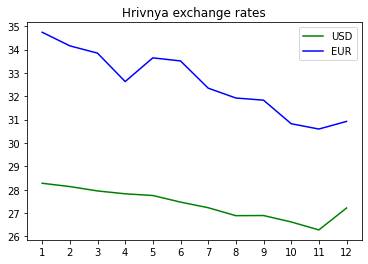

In [ ]:
import urllib.parse
from urllib.request import urlopen
import json
import re
import os
import requests
import csv
from pprint import pprint
from dynamodb_json import json_util as ujson
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# pandas, matplotlib, dynamodb-json
main_part = 'https://bank.gov.ua/NBUStatService/v1/statdirectory/exchangenew?json&'


date = '20210001'

data = []
exchange_list = []
n = 12
for i in range(n):

  # os.remove(f'exchange{i+1}.json')
  date = str(int(date)+100)
  url = main_part + urllib.parse.urlencode({'date':date})
  # print(url)

  response = requests.get(url)
  json_list = response.json()
  # json_data = json.loads(response.text)
  # print(json_list == json_data)

  data.append(json_list)
  # json_string = json.dumps(json_list, ensure_ascii=False)
  # dynamodb_json = ujson.dumps(json_list[0], ensure_ascii=False)
  for i in range(len(json_list)):
    if(json_list[i]["cc"] in ("USD", "EUR")):
      # print(json_list[i])
      record = {
        "PutRequest": {
            "Item": json.loads(ujson.dumps(json_list[i]))
        }
      }
      exchange_list.append(record)

exchange = {"Exchange" : exchange_list}

with open('exchange.json', 'w') as json_file:
  json_file.write(json.dumps(exchange, ensure_ascii=False, indent = 4))


for i in range(n):
  with open(f'exchange{i+1}.csv', 'w') as f:
    writer = csv. DictWriter(f, data[0][0].keys())
    writer.writeheader()

    for currency in data[i]:
      writer.writerow(currency)
# print(json_data[0].keys())
# print(data[0][0].keys())
usd = []
eur = []
for i in range(n):
  df = pd.read_csv(f'exchange{i+1}.csv', index_col = 'r030') 
  dollar = df[df['cc'] == 'USD']['rate']
  usd.append(dollar.values[0])
  euro = df[df['cc'] == 'EUR']['rate']
  eur.append(euro.values[0])

print(usd)
print(eur)


x = [i+1 for i in range(n)]
y = np.array(usd)
plt.plot(x, y, label='USD', color="green")

x = [i+1 for i in range(n)]
z = np.array(eur)
plt.plot(x, z, label='EUR', color="blue")

plt.title("Hrivnya exchange rates")
plt.legend()
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.yticks(np.arange(round(min(y)), round(max(z))+1, 1.0))
plt.savefig('exchange_rates.png')
plt.show()


# import boto3
# s3 = boto3.client('s3')
# for i in range(0,12):
#   s3.upload_file(f'exchange{i+1}.csv', 'cl0udbucket', f'exchange{i+1}.csv')

# obj = s3.get_object(Bucket= 'cl0udbucket', Key= f'exchange{i+1}.csv') 

# initial_df = pd.read_csv(obj['Body'])

In [ ]:
import boto3
import pandas as pd
s3 = boto3.client('s3')
for i in range(0,12):
    obj = s3.get_object(Bucket= 'cl0udbucket', Key= f'exchange{i+1}.csv') 
    df = pd.read_csv(obj['Body'])
    print(df.head())

   r030                   txt     rate   cc exchangedate
0    36  Австралійський долар  21.6852  AUD   01.01.2021
1   124      Канадський долар  22.1154  CAD   01.01.2021
2   156       Юань Женьміньбі   4.3333  CNY   01.01.2021
3   191                  Куна   4.6037  HRK   01.01.2021
4   203          Чеська крона   1.3238  CZK   01.01.2021
   r030                   txt     rate   cc exchangedate
0    36  Австралійський долар  21.5860  AUD   01.02.2021
1   124      Канадський долар  22.0042  CAD   01.02.2021
2   156       Юань Женьміньбі   4.3767  CNY   01.02.2021
3   191                  Куна   4.5145  HRK   01.02.2021
4   203          Чеська крона   1.3135  CZK   01.02.2021
   r030                   txt     rate   cc exchangedate
0    36  Австралійський долар  21.6732  AUD   01.03.2021
1   124      Канадський долар  22.0827  CAD   01.03.2021
2   156       Юань Женьміньбі   4.3220  CNY   01.03.2021
3   191                  Куна   4.4642  HRK   01.03.2021
4   203          Чеська крона  

In [ ]:
import boto3
dynamodb = boto3.resource('dynamodb')

table = dynamodb.create_table (
    TableName = 'ExchangeRatesSDK',
       KeySchema = [
           {
               'AttributeName': 'cc',
               'KeyType': 'HASH'
           },
           {
               'AttributeName': 'exchangedate',
               'KeyType': 'RANGE'
           }
           ],
           AttributeDefinitions = [
               {
                   'AttributeName': 'cc',
                   'AttributeType': 'S'
               },
               {
                   'AttributeName':'exchangedate',
                   'AttributeType': 'S'
               }
            ],
            ProvisionedThroughput={
                'ReadCapacityUnits':1,
                'WriteCapacityUnits':1
            }
          
    )
print(table)

dynamodb.Table(name='ExchangeRatesSDK')


In [ ]:
from pprint import pprint
table = dynamodb.Table('ExchangeRatesSDK')
response = table.put_item(
Item = { 
     'r030': 36,
     'txt': 'Австралійський долар',
     'rate': '21.6852',
     'cc': 'AUD',
     'exchangedate': '01.01.2021'
       }
)
pprint(response)

{'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
                                      'content-length': '2',
                                      'content-type': 'application/x-amz-json-1.0',
                                      'date': 'Sun, 10 Apr 2022 11:58:06 GMT',
                                      'server': 'Server',
                                      'x-amz-crc32': '2745614147',
                                      'x-amzn-requestid': '4GIC728IIAOA8LHBLSPKQKE6K3VV4KQNSO5AEMVJF66Q9ASUAAJG'},
                      'HTTPStatusCode': 200,
                      'RequestId': '4GIC728IIAOA8LHBLSPKQKE6K3VV4KQNSO5AEMVJF66Q9ASUAAJG',
                      'RetryAttempts': 0}}


In [ ]:
import boto3
import csv

s3 = boto3.client('s3')
items = []
for i in range(0,12):
    obj = s3.get_object(Bucket= 'cl0udbucket', Key= f'exchange{i+1}.csv') 
    lines =obj['Body'].read().decode('utf-8').splitlines(True)
    reader = csv.DictReader(lines)
    for row in reader:
      if row['cc'] in ("USD", "EUR"):
        data = {}
        data['r030'] = row['r030']
        data['txt'] = row['txt']
        data['rate'] = row['rate']
        data['cc'] = row['cc']
        data['exchangedate'] = row['exchangedate']
        items.append(data)

dynamodb = boto3.resource('dynamodb')
table = dynamodb.Table('ExchangeRatesSDK')
with table.batch_writer() as batch:
      for item in items:
         batch.put_item(Item=item)
print(batch)

In [ ]:
import boto3
from boto3.dynamodb.conditions import Key
from pprint import pprint

dynamodb = boto3.resource('dynamodb')
table = dynamodb.Table('ExchangeRatesSDK')

response = table.query(KeyConditionExpression=Key('cc').eq('EUR'))

print("The number of returned items: ", len(response['Items']))
print("The query returned the following items:")
for item in response['Items']:
    pprint(item)

The number of returned items:  12
The query returned the following items:
{'cc': 'EUR',
 'exchangedate': '01.01.2021',
 'r030': '978',
 'rate': '34.7396',
 'txt': 'Євро'}
{'cc': 'EUR',
 'exchangedate': '01.02.2021',
 'r030': '978',
 'rate': '34.157',
 'txt': 'Євро'}
{'cc': 'EUR',
 'exchangedate': '01.03.2021',
 'r030': '978',
 'rate': '33.8449',
 'txt': 'Євро'}
{'cc': 'EUR',
 'exchangedate': '01.04.2021',
 'r030': '978',
 'rate': '32.629',
 'txt': 'Євро'}
{'cc': 'EUR',
 'exchangedate': '01.05.2021',
 'r030': '978',
 'rate': '33.6427',
 'txt': 'Євро'}
{'cc': 'EUR',
 'exchangedate': '01.06.2021',
 'r030': '978',
 'rate': '33.5116',
 'txt': 'Євро'}
{'cc': 'EUR',
 'exchangedate': '01.07.2021',
 'r030': '978',
 'rate': '32.3463',
 'txt': 'Євро'}
{'cc': 'EUR',
 'exchangedate': '01.08.2021',
 'r030': '978',
 'rate': '31.9239',
 'txt': 'Євро'}
{'cc': 'EUR',
 'exchangedate': '01.09.2021',
 'r030': '978',
 'rate': '31.8317',
 'txt': 'Євро'}
{'cc': 'EUR',
 'exchangedate': '01.10.2021',
 'r030': '

In [ ]:
import boto3
from boto3.dynamodb.conditions import Key, Attr
from pprint import pprint

dynamodb = boto3.resource('dynamodb')
table = dynamodb.Table('ExchangeRatesSDK')

response = table.scan(FilterExpression=Attr('exchangedate').eq('01.01.2021'))

print("The number of returned items: ", len(response['Items']))
print("The query returned the following items:")
for item in response['Items']:
    pprint(item)

The number of returned items:  3
The query returned the following items:
{'cc': 'EUR',
 'exchangedate': '01.01.2021',
 'r030': '978',
 'rate': '34.7396',
 'txt': 'Євро'}
{'cc': 'USD',
 'exchangedate': '01.01.2021',
 'r030': '840',
 'rate': '28.2746',
 'txt': 'Долар США'}
{'cc': 'AUD',
 'exchangedate': '01.01.2021',
 'r030': Decimal('36'),
 'rate': '21.6852',
 'txt': 'Австралійський долар'}


In [ ]:
import boto3
from pprint import pprint

dynamodb = boto3.resource('dynamodb')
table = dynamodb.Table('ExchangeRatesSDK')

response = table.delete_item(Key = {'cc': 'AUD', 'exchangedate': '01.01.2021'})

pprint(response)

{'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
                                      'content-length': '2',
                                      'content-type': 'application/x-amz-json-1.0',
                                      'date': 'Sun, 10 Apr 2022 11:58:16 GMT',
                                      'server': 'Server',
                                      'x-amz-crc32': '2745614147',
                                      'x-amzn-requestid': 'SK0KSU6HO2HD8MUL49QL7ABVS3VV4KQNSO5AEMVJF66Q9ASUAAJG'},
                      'HTTPStatusCode': 200,
                      'RequestId': 'SK0KSU6HO2HD8MUL49QL7ABVS3VV4KQNSO5AEMVJF66Q9ASUAAJG',
                      'RetryAttempts': 0}}
